<a href="https://colab.research.google.com/github/Sam-415/Marketing-research-methods---Samhita_-Jio-Institute/blob/12th-Feb/12th_Feb_MRM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

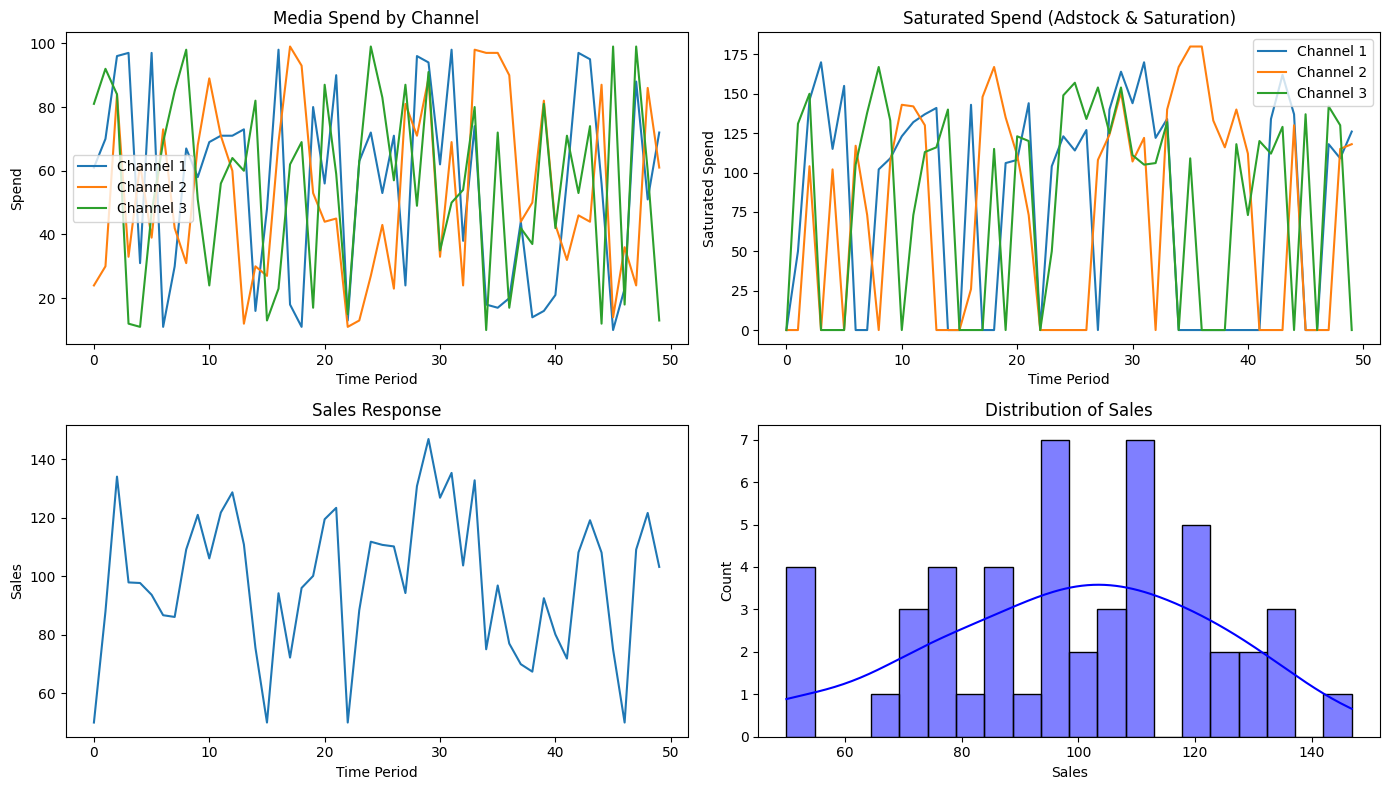

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function for Adstock effect
def adstock_effect(media_spend, decay_rate):
    """
    Apply adstock transformation to media spend.
    """
    adstock = np.zeros_like(media_spend)
    adstock[0] = media_spend[0]

    for t in range(1, len(media_spend)):
        adstock[t] = media_spend[t] + decay_rate * adstock[t - 1]  # carryover effect

    return adstock

# Function for Saturation effect
def saturation_effect(adstocked_media, saturation_point):
    """
    Apply saturation effect to adstocked media spend.
    """
    return adstocked_media / (1 + np.exp(-(adstocked_media - saturation_point)))

# Simulate the Marketing Mix Model (MMM)
def simulate_mmm(n_periods=50, decay_rate=0.5, saturation_point=100, channel_count=3):
    # Generate random marketing spend for 3 channels (media spend)
    np.random.seed(42)
    media_spend = np.random.randint(10, 100, size=(n_periods, channel_count))

    # Initialize DataFrame for the results
    data = pd.DataFrame(media_spend, columns=[f"Channel {i+1}" for i in range(channel_count)])

    # Apply adstock effect to each channel
    adstocked_spend = np.zeros_like(media_spend)
    for i in range(channel_count):
        adstocked_spend[:, i] = adstock_effect(media_spend[:, i], decay_rate)

    # Apply saturation effect to adstocked media spend
    saturated_spend = np.zeros_like(adstocked_spend)
    for i in range(channel_count):
        saturated_spend[:, i] = saturation_effect(adstocked_spend[:, i], saturation_point)

    # Simulate sales (response) based on media spend
    # Simple response model: Response = Base + ∑(Saturated Spend * Coefficients)
    base_sales = 50  # Base sales value (without marketing)
    coefficients = np.random.uniform(0.1, 0.3, size=channel_count)  # Random coefficients for each channel

    sales_response = base_sales + np.dot(saturated_spend, coefficients)

    # Combine into a DataFrame for plotting
    result_df = pd.DataFrame(saturated_spend, columns=[f"Channel {i+1}" for i in range(channel_count)])
    result_df['Sales'] = sales_response

    return result_df, media_spend

# Simulate the model
result_df, media_spend = simulate_mmm()

# Plot the media spend, adstock, saturation effect, and sales
plt.figure(figsize=(14, 8))

# Plot Media Spend
plt.subplot(2, 2, 1)
plt.plot(media_spend)
plt.title('Media Spend by Channel')
plt.xlabel('Time Period')
plt.ylabel('Spend')
plt.legend([f'Channel {i+1}' for i in range(media_spend.shape[1])])

# Plot Saturated Spend (after Adstock and Saturation)
plt.subplot(2, 2, 2)
plt.plot(result_df.iloc[:, :-1])
plt.title('Saturated Spend (Adstock & Saturation)')
plt.xlabel('Time Period')
plt.ylabel('Saturated Spend')
plt.legend([f'Channel {i+1}' for i in range(result_df.shape[1] - 1)])

# Plot Sales Response
plt.subplot(2, 2, 3)
plt.plot(result_df['Sales'])
plt.title('Sales Response')
plt.xlabel('Time Period')
plt.ylabel('Sales')

# Distribution of Coefficients
plt.subplot(2, 2, 4)
sns.histplot(result_df['Sales'], kde=True, color='blue', bins=20)
plt.title('Distribution of Sales')

plt.tight_layout()
plt.show()

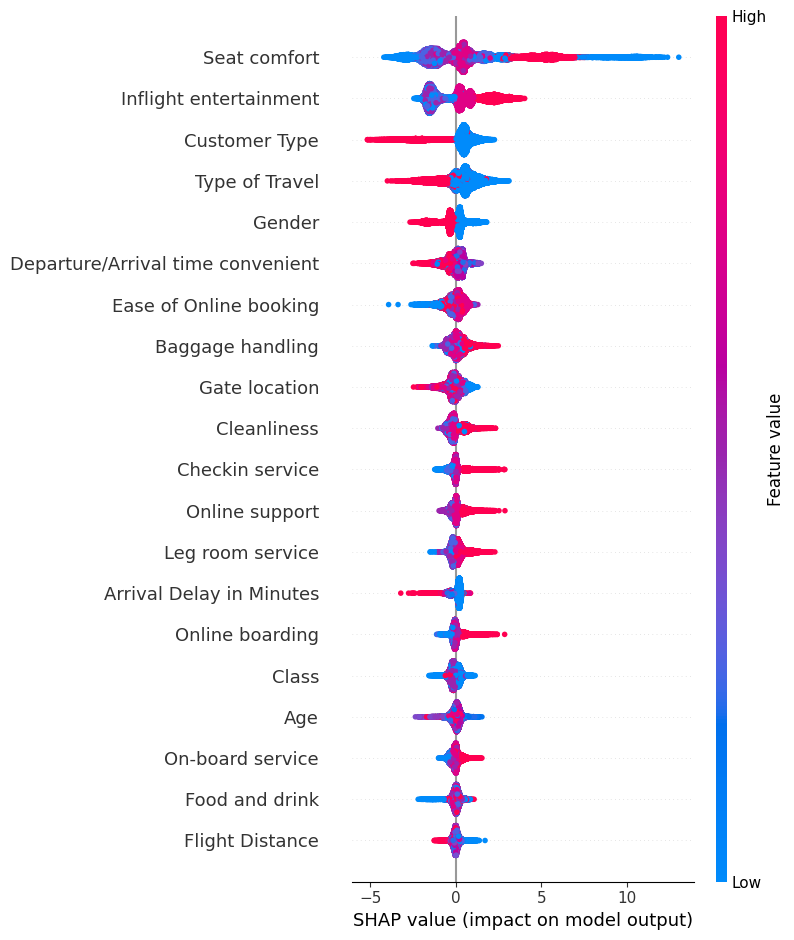

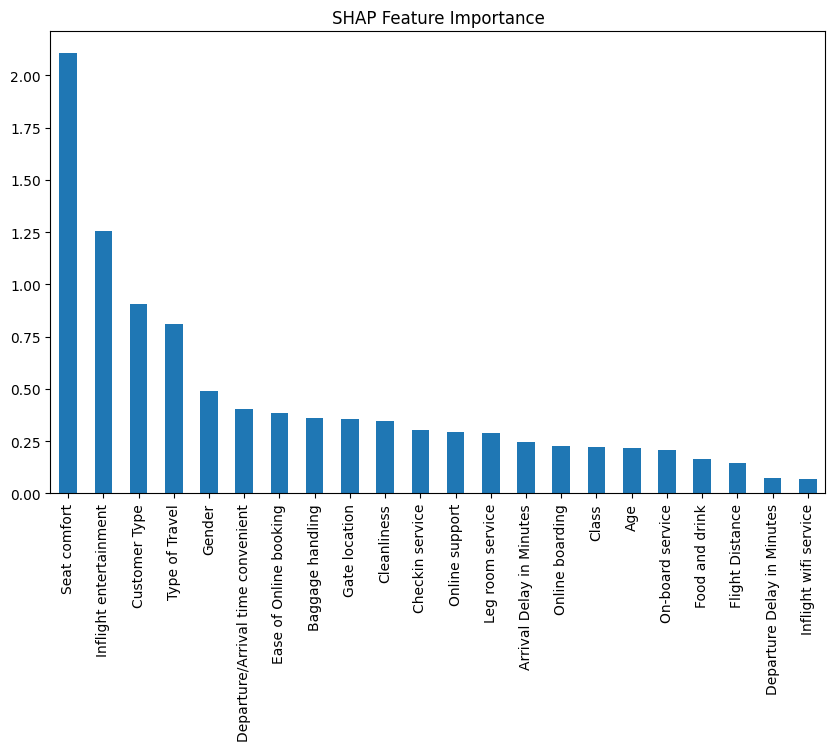

In [ ]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load dataset
file_path = "/content/Invistico_Airline.csv"  # Update with the correct path
df = pd.read_csv(file_path)

# Encode categorical variables
label_encoders = {}
for col in ["Gender", "Customer Type", "Type of Travel", "Class"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Save encoders for reference

# Convert satisfaction to binary (0 = Dissatisfied, 1 = Satisfied)
df["satisfaction"] = df["satisfaction"].apply(lambda x: 1 if x == "satisfied" else 0)

# Define independent and dependent variables
X = df.drop(columns=["satisfaction"])
y = df["satisfaction"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# SHAP Analysis
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Summary plot (Feature Importance)
shap.summary_plot(shap_values, X_test)

# Bar plot for mean SHAP values
shap_values_df = pd.DataFrame(shap_values.values, columns=X_test.columns)
shap_mean = shap_values_df.abs().mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
shap_mean.plot(kind="bar", title="SHAP Feature Importance")
plt.show()

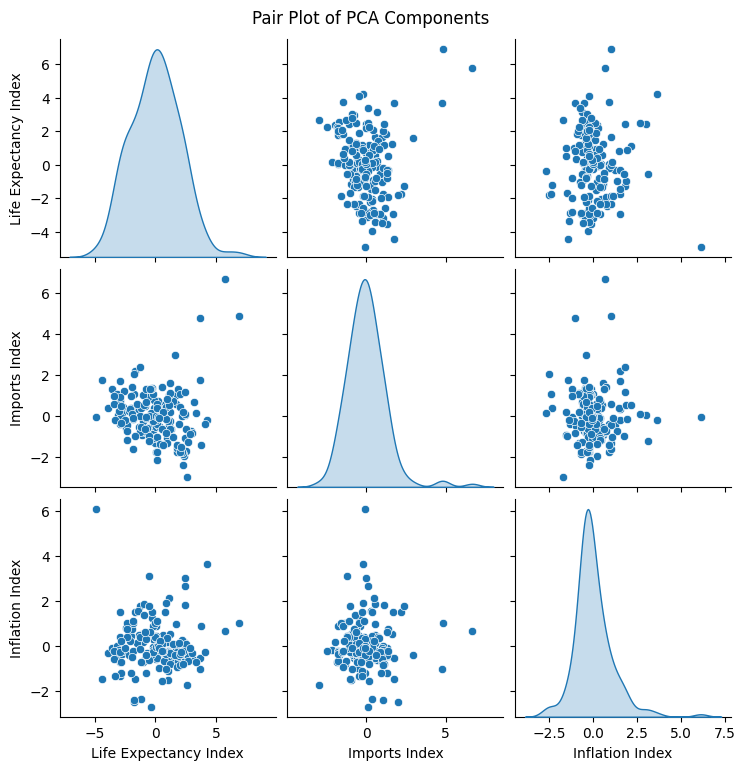

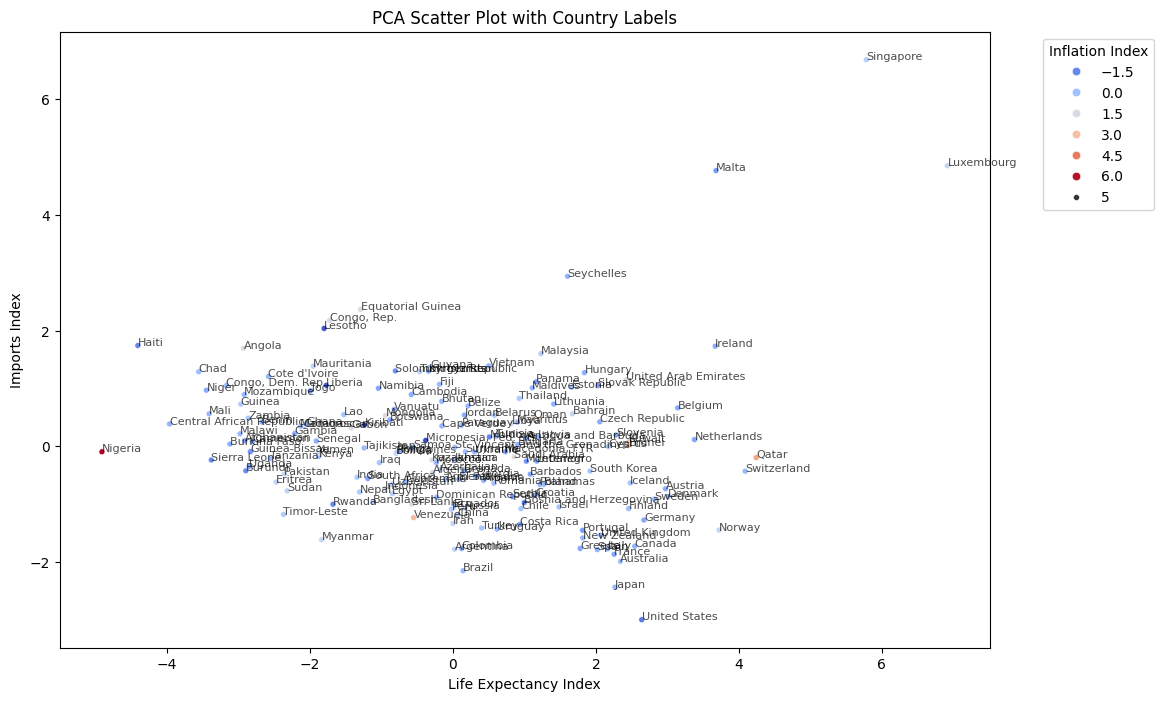

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load the dataset
file_path = "/content/pca.csv"
df = pd.read_csv(file_path)

# Drop the 'country' column for PCA
country_names = df['country']
df_numeric = df.drop(columns=['country'])

# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

# Apply PCA to reduce dimensions to 3
pca = PCA(n_components=3)
principal_components = pca.fit_transform(df_scaled)

# Create a new DataFrame with renamed components
pca_df = pd.DataFrame(principal_components, columns=["Life Expectancy Index", "Imports Index", "Inflation Index"])
pca_df["country"] = country_names

# Pair plot for better interpretation
sns.pairplot(pca_df, diag_kind='kde', markers="o", hue=None)
plt.suptitle("Pair Plot of PCA Components", y=1.02)
plt.show()

# Scatter plot with labels for countries
plt.figure(figsize=(12, 8))
sns.scatterplot(x=pca_df["Life Expectancy Index"], y=pca_df["Imports Index"], hue=pca_df["Inflation Index"], palette="coolwarm", size=5)

# Annotate country names
for i, txt in enumerate(country_names):
    plt.annotate(txt, (pca_df["Life Expectancy Index"][i], pca_df["Imports Index"][i]), fontsize=8, alpha=0.7)

plt.xlabel("Life Expectancy Index")
plt.ylabel("Imports Index")
plt.title("PCA Scatter Plot with Country Labels")
plt.legend(title="Inflation Index", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

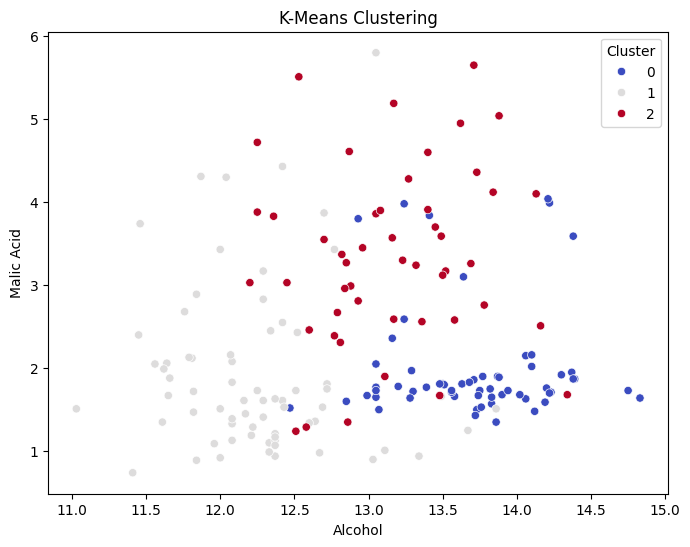

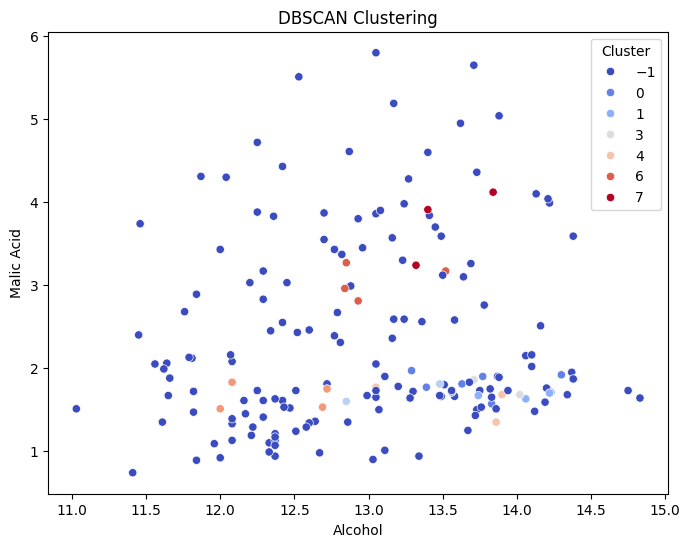

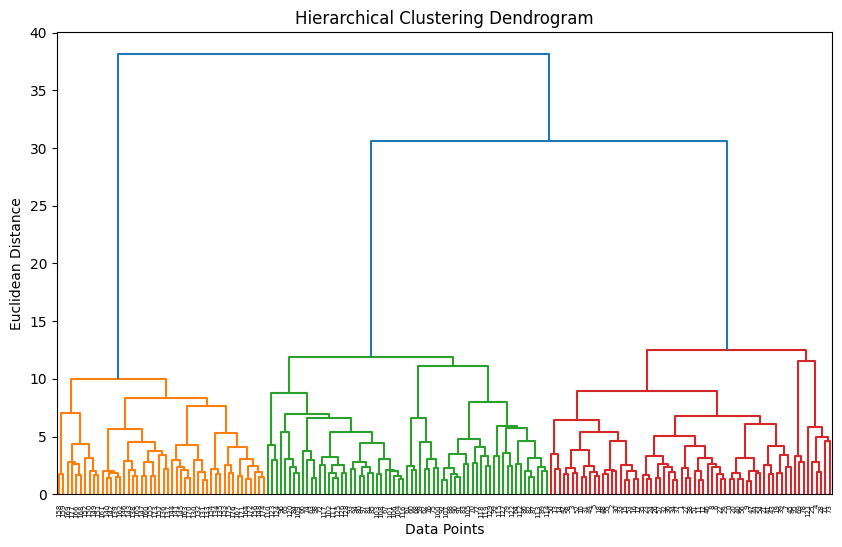

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch

# Load the dataset
file_path = "/content/wine_Dataset.csv"  # Update with the actual path if needed
df = pd.read_csv(file_path)

# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# ======= K-Means Clustering =======
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)  # Adjust clusters as needed
df["KMeans_Cluster"] = kmeans.fit_predict(df_scaled)

# Plot K-Means Clustering
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["Alcohol"], y=df["Malic"], hue=df["KMeans_Cluster"], palette="coolwarm")
plt.title("K-Means Clustering")
plt.xlabel("Alcohol")
plt.ylabel("Malic Acid")
plt.legend(title="Cluster")
plt.show()

# ======= Density-Based Clustering (DBSCAN) =======
dbscan = DBSCAN(eps=1.5, min_samples=3)  # Adjust eps & min_samples as needed
df["DBSCAN_Cluster"] = dbscan.fit_predict(df_scaled)

# Plot DBSCAN Clustering
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["Alcohol"], y=df["Malic"], hue=df["DBSCAN_Cluster"], palette="coolwarm")
plt.title("DBSCAN Clustering")
plt.xlabel("Alcohol")
plt.ylabel("Malic Acid")
plt.legend(title="Cluster")
plt.show()

# ======= Hierarchical Clustering =======
hierarchical = AgglomerativeClustering(n_clusters=3)  # Adjust clusters as needed
df["Hierarchical_Cluster"] = hierarchical.fit_predict(df_scaled)

# Dendrogram for Hierarchical Clustering
plt.figure(figsize=(10, 6))
dendrogram = sch.dendrogram(sch.linkage(df_scaled, method="ward"))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()

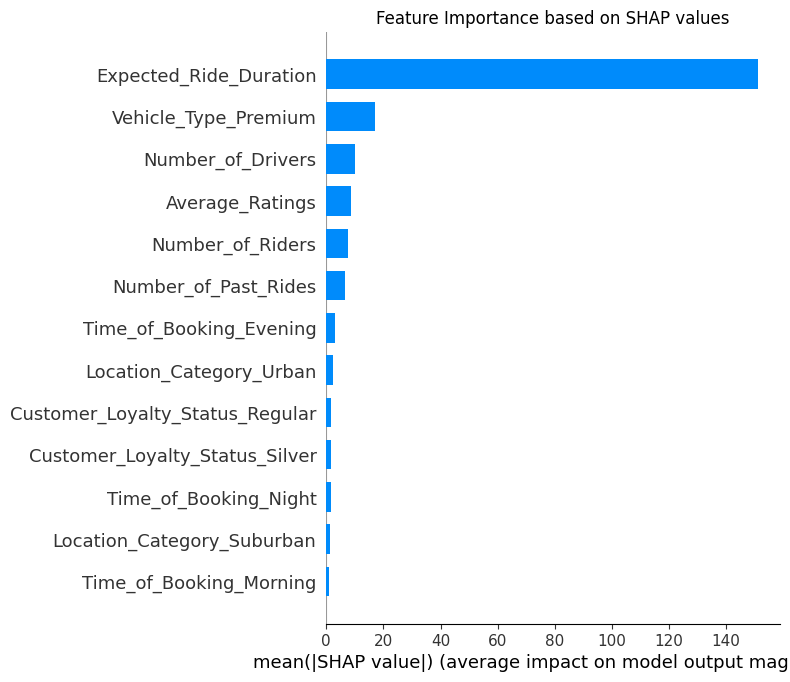

<ipython-input-11-bea668a1e717>:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Mean |SHAP|", y="Feature", data=importance_df, palette="viridis")


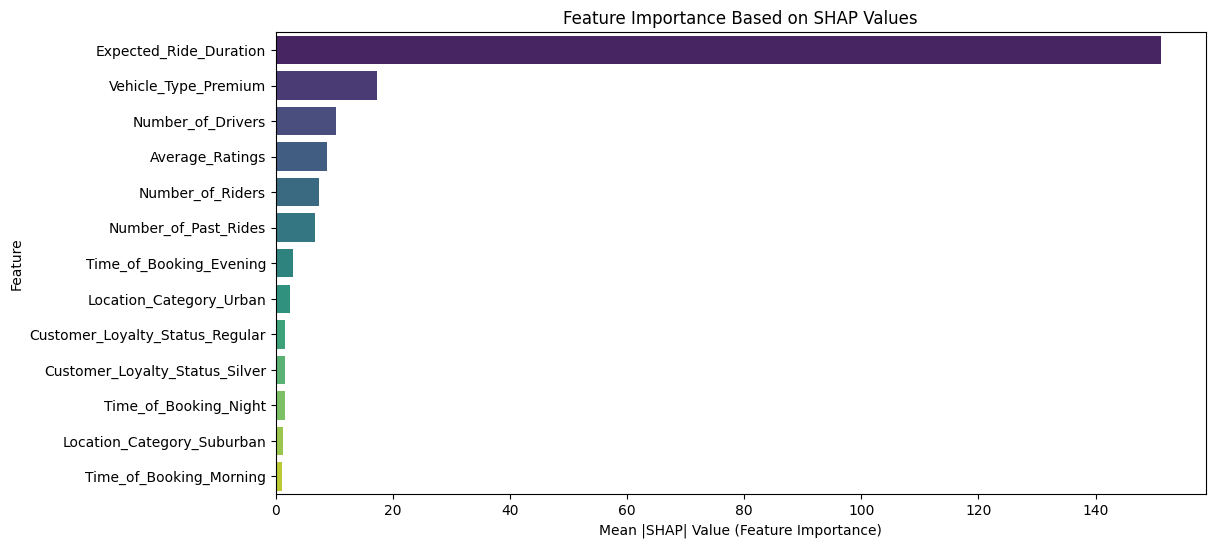

Feature Importance (Sorted by Mean Absolute SHAP Value):
                            Feature  Mean |SHAP|
4            Expected_Ride_Duration   151.263855
12             Vehicle_Type_Premium    17.206545
1                 Number_of_Drivers    10.237095
3                   Average_Ratings     8.820980
0                  Number_of_Riders     7.464537
2              Number_of_Past_Rides     6.725108
9           Time_of_Booking_Evening     3.001174
6           Location_Category_Urban     2.360497
7   Customer_Loyalty_Status_Regular     1.647115
8    Customer_Loyalty_Status_Silver     1.606635
11            Time_of_Booking_Night     1.556639
5        Location_Category_Suburban     1.172460
10          Time_of_Booking_Morning     1.083350


In [ ]:
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# -----------------------------
# 1. Load the dataset
# -----------------------------
file_path = "/content/dynamic_pricing.csv"  # Update if needed
df = pd.read_csv(file_path)

# -----------------------------
# 2. Preprocess the data
# -----------------------------
# Categorical columns to convert into dummy variables
categorical_cols = ["Location_Category", "Customer_Loyalty_Status", "Time_of_Booking", "Vehicle_Type"]
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Define features (X) and target (y)
X = df_encoded.drop(columns=["Historical_Cost_of_Ride"])
y = df_encoded["Historical_Cost_of_Ride"]

# Split into training and testing sets (optional)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -----------------------------
# 3. Train an XGBoost model
# -----------------------------
model = xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
model.fit(X_train, y_train)

# -----------------------------
# 4. SHAP Analysis
# -----------------------------
# Use TreeExplainer (faster for XGBoost)
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

# Plot summary bar plot of SHAP values
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("Feature Importance based on SHAP values")
plt.show()

# -----------------------------
# 5. Improved Feature Importance Visualization
# -----------------------------
# Compute mean absolute SHAP values
shap_abs = np.abs(shap_values.values)
mean_shap = np.mean(shap_abs, axis=0)

# Create DataFrame for visualization
importance_df = pd.DataFrame({"Feature": X.columns, "Mean |SHAP|": mean_shap})
importance_df = importance_df.sort_values(by="Mean |SHAP|", ascending=False)

# Plot feature importance using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x="Mean |SHAP|", y="Feature", data=importance_df, palette="viridis")
plt.xlabel("Mean |SHAP| Value (Feature Importance)")
plt.ylabel("Feature")
plt.title("Feature Importance Based on SHAP Values")
plt.show()

# Print feature importance table
print("Feature Importance (Sorted by Mean Absolute SHAP Value):")
print(importance_df)

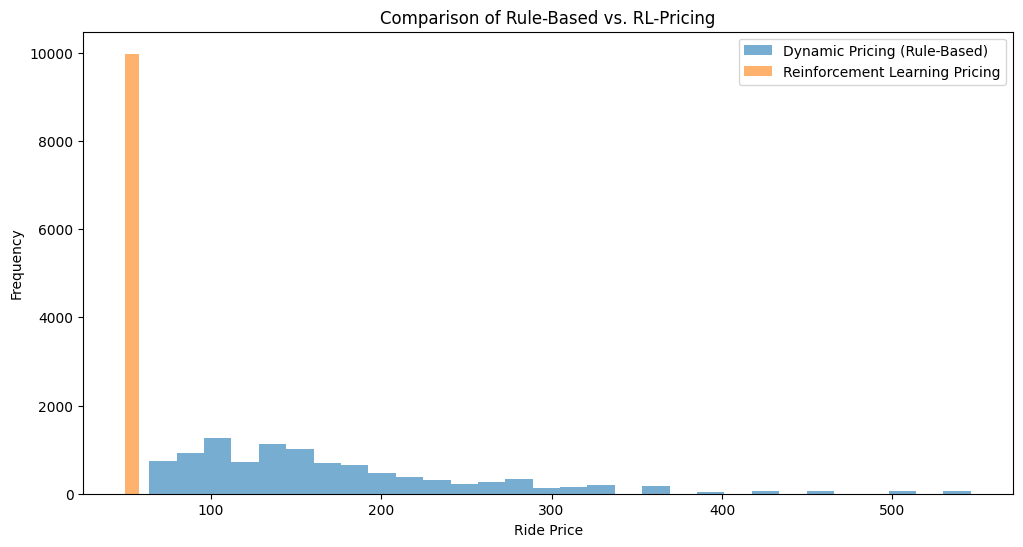

     Demand_Level Driver_Availability Time_of_Day Vehicle_Type  Dynamic_Price  \
5478       Medium                Many   Afternoon      Economy           88.0   
1254       Medium                 Few     Evening      Economy          182.0   
4134       Medium            Moderate     Morning      Premium          200.0   
8035          Low                Many       Night      Premium          153.6   
6857          Low                 Few     Morning      Premium          224.0   
1517         High                 Few       Night      Premium          504.0   
1097          Low                Many     Evening      Premium          166.4   
7030       Medium            Moderate     Morning      Economy          100.0   
3443         High            Moderate     Morning      Economy          150.0   
4392       Medium                 Few     Evening      Economy          182.0   

      Optimal_RL_Price  
5478                50  
1254                50  
4134                50  
8035    

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# -----------------------------
# 1. Generate Simulated Data
# -----------------------------
n_samples = 10000  # Number of simulated rides
data = pd.DataFrame({
    "Demand_Level": np.random.choice(["Low", "Medium", "High"], size=n_samples, p=[0.3, 0.5, 0.2]),
    "Driver_Availability": np.random.choice(["Few", "Moderate", "Many"], size=n_samples, p=[0.4, 0.4, 0.2]),
    "Time_of_Day": np.random.choice(["Morning", "Afternoon", "Evening", "Night"], size=n_samples),
    "Vehicle_Type": np.random.choice(["Economy", "Premium"], size=n_samples, p=[0.7, 0.3]),
})

# Define base prices
base_price = {"Economy": 100, "Premium": 200}

# Dynamic factors influencing price
def compute_dynamic_price(row):
    demand_factor = {"Low": 0.8, "Medium": 1.0, "High": 1.5}
    driver_factor = {"Few": 1.4, "Moderate": 1.0, "Many": 0.8}
    time_factor = {"Morning": 1.0, "Afternoon": 1.1, "Evening": 1.3, "Night": 1.2}

    price = base_price[row["Vehicle_Type"]] * demand_factor[row["Demand_Level"]] \
            * driver_factor[row["Driver_Availability"]] * time_factor[row["Time_of_Day"]]
    return round(price, 2)

data["Dynamic_Price"] = data.apply(compute_dynamic_price, axis=1)

# -----------------------------
# 2. Define Reinforcement Learning Environment
# -----------------------------
price_range = np.arange(50, 300, 10)  # Possible price points
n_actions = len(price_range)
n_states = len(data)  # Unique ride scenarios

# Initialize Q-table (states x actions)
Q_table = np.zeros((n_states, n_actions))

# -----------------------------
# 3. Q-Learning Algorithm for Dynamic Pricing
# -----------------------------
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.2  # Exploration probability
episodes = 50  # Number of training iterations

# Reward function: Higher price = higher revenue, but high price can lower demand
def get_reward(state, action):
    actual_price = price_range[action]
    optimal_price = data.iloc[state]["Dynamic_Price"]

    # Reward is based on closeness to dynamic price (higher is better)
    return max(0, 1 - abs(actual_price - optimal_price) / optimal_price)

# Q-learning loop
for episode in range(episodes):
    state = np.random.randint(0, n_states)  # Random starting state

    for _ in range(100):  # Limit iterations per episode
        # Choose action (ε-greedy)
        if np.random.rand() < epsilon:
            action = np.random.randint(0, n_actions)  # Explore
        else:
            action = np.argmax(Q_table[state])  # Exploit best known action

        # Get reward
        reward = get_reward(state, action)

        # Update Q-table
        Q_table[state, action] = Q_table[state, action] + alpha * (reward + gamma * np.max(Q_table[state]) - Q_table[state, action])

# -----------------------------
# 4. Evaluate Pricing Strategy
# -----------------------------
optimal_prices = []
for state in range(n_states):
    best_action = np.argmax(Q_table[state])
    optimal_prices.append(price_range[best_action])

data["Optimal_RL_Price"] = optimal_prices

# Compare Prices
plt.figure(figsize=(12, 6))
plt.hist(data["Dynamic_Price"], bins=30, alpha=0.6, label="Dynamic Pricing (Rule-Based)")
plt.hist(data["Optimal_RL_Price"], bins=30, alpha=0.6, label="Reinforcement Learning Pricing")
plt.xlabel("Ride Price")
plt.ylabel("Frequency")
plt.title("Comparison of Rule-Based vs. RL-Pricing")
plt.legend()
plt.show()

# Show sample results
print(data.sample(10))

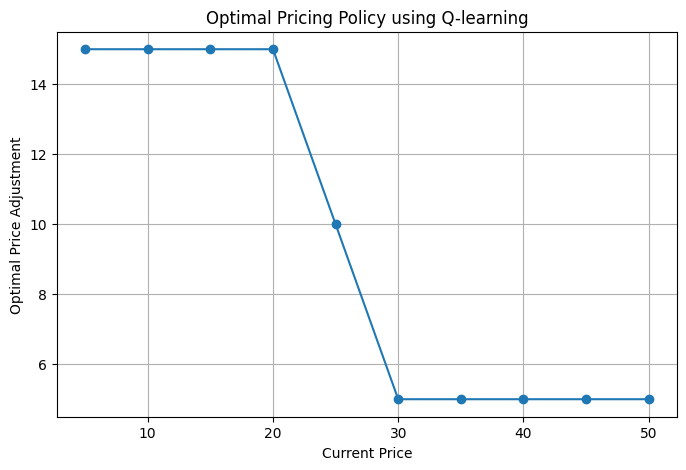

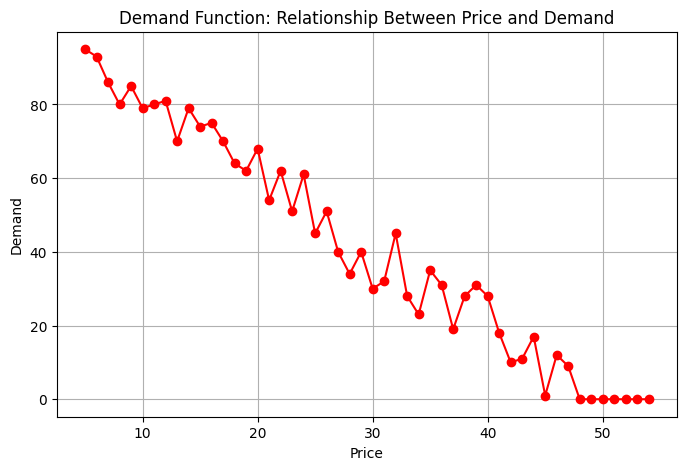


Q-learning Pricing Policy Q-table:
       Action -5      Action 0      Action 5
5    9221.120605   8415.514140  11670.282033
10  10104.366125  11419.582466  12082.320661
15  11658.338950  12124.749951  12278.171588
20  12087.835380  12295.989700  12394.728401
25  12285.635954  12362.672828  12227.370920
30  12336.134313  12265.156072  12084.498105
35  12332.207451  11973.919624  11718.755855
40  12021.033701  10294.039160   9961.298688
45  11647.625286   7239.099675   8469.931597
50  10915.370585   6152.224657   6856.801948


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

# Simulated demand function: Demand decreases as price increases
def demand_function(price):
    base_demand = 100  # Maximum demand at lowest price
    return max(0, base_demand - 2 * price + np.random.randint(-10, 10))  # Adding randomness

# Define Environment
price_levels = np.arange(5, 55, 5)  # Possible price levels from 5 to 50 in steps of 5
actions = [-5, 0, 5]  # Possible price adjustments: decrease, same, increase
Q_table = np.zeros((len(price_levels), len(actions)))  # Q-table initialization

# Hyperparameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.2  # Exploration probability
episodes = 1000

# Training the Q-learning model
for episode in range(episodes):
    current_price = random.choice(price_levels)  # Start with a random price

    for _ in range(50):  # Each episode consists of multiple steps
        state_index = np.where(price_levels == current_price)[0][0]

        # Epsilon-greedy strategy
        if random.uniform(0, 1) < epsilon:
            action_index = random.choice(range(len(actions)))  # Explore
        else:
            action_index = np.argmax(Q_table[state_index])  # Exploit

        action = actions[action_index]
        new_price = max(5, min(50, current_price + action))  # Ensure price stays in range
        new_state_index = np.where(price_levels == new_price)[0][0]

        # Compute reward (Revenue = Price × Demand)
        revenue = new_price * demand_function(new_price)
        reward = revenue  # Reward is revenue

        # Q-learning update rule
        Q_table[state_index, action_index] += alpha * (reward + gamma * np.max(Q_table[new_state_index]) - Q_table[state_index, action_index])

        # Move to new price
        current_price = new_price

# Extract optimal pricing policy
optimal_policy = [price_levels[np.argmax(Q_table[i])] for i in range(len(price_levels))]

# Plot the optimal pricing policy
plt.figure(figsize=(8, 5))
plt.plot(price_levels, optimal_policy, marker='o', linestyle='-')
plt.xlabel("Current Price")
plt.ylabel("Optimal Price Adjustment")
plt.title("Optimal Pricing Policy using Q-learning")
plt.grid()
plt.show()

# Plot the Demand Function
prices = np.arange(5, 55, 1)
demands = [demand_function(p) for p in prices]

plt.figure(figsize=(8, 5))
plt.plot(prices, demands, marker='o', linestyle='-', color='red')
plt.xlabel("Price")
plt.ylabel("Demand")
plt.title("Demand Function: Relationship Between Price and Demand")
plt.grid()
plt.show()

# Display final Q-table
df = pd.DataFrame(Q_table, index=price_levels, columns=[f"Action {a}" for a in actions])
print("\nQ-learning Pricing Policy Q-table:")
print(df)

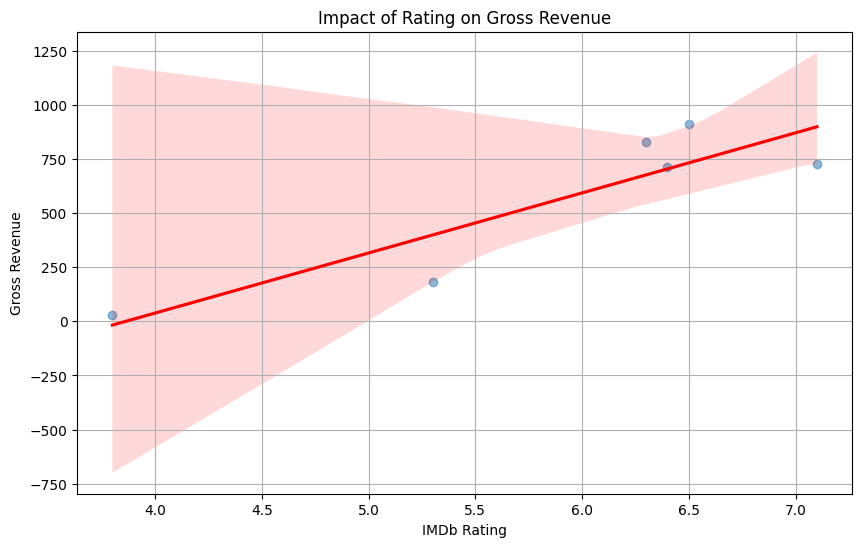

Correlation between Rating and Gross Revenue: 0.90
R-squared value: 0.80


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Load dataset (detect file type)
file_path = "/content/crime_series.csv"  # Update with the correct file path

# Check if the file is CSV or Excel
if file_path.endswith(".csv"):
    df = pd.read_csv(file_path)
elif file_path.endswith((".xls", ".xlsx")):
    df = pd.read_excel(file_path, engine="openpyxl")  # Use openpyxl for newer Excel files

# Convert columns to numeric types, handling errors
df["Rating"] = pd.to_numeric(df["Rating"], errors='coerce')
df["Gross Revenue"] = pd.to_numeric(df["Gross Revenue"], errors='coerce')

# Drop rows with missing values in the relevant columns
df = df.dropna(subset=["Rating", "Gross Revenue"])

# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=df["Rating"], y=df["Gross Revenue"], scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.xlabel("IMDb Rating")
plt.ylabel("Gross Revenue")
plt.title("Impact of Rating on Gross Revenue")
plt.grid(True)
plt.show()

# Correlation coefficient
correlation = df["Rating"].corr(df["Gross Revenue"])
print(f"Correlation between Rating and Gross Revenue: {correlation:.2f}")

# Linear Regression Model
X = df["Rating"].values.reshape(-1, 1)
y = df["Gross Revenue"].values.reshape(-1, 1)

model = LinearRegression()
model.fit(X, y)
r_squared = model.score(X, y)
print(f"R-squared value: {r_squared:.2f}")

DEBUG:cmdstanpy:input tempfile: /tmp/tmpwnkr20bh/ggq6l58y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwnkr20bh/2ho80pmn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89778', 'data', 'file=/tmp/tmpwnkr20bh/ggq6l58y.json', 'init=/tmp/tmpwnkr20bh/2ho80pmn.json', 'output', 'file=/tmp/tmpwnkr20bh/prophet_modelwp14phkk/prophet_model-20250216144436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:44:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:44:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<Figure size 1200x600 with 0 Axes>

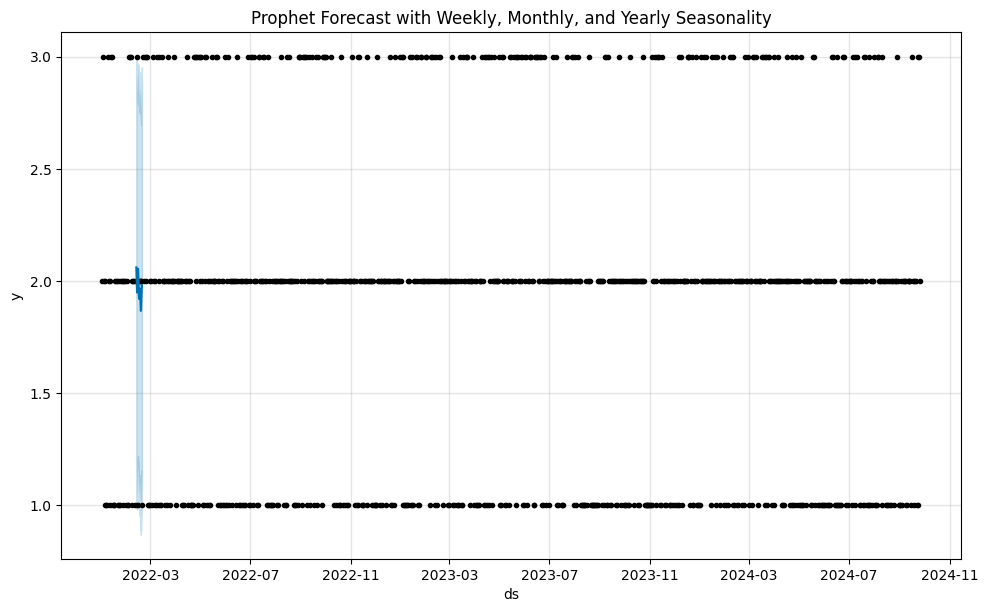

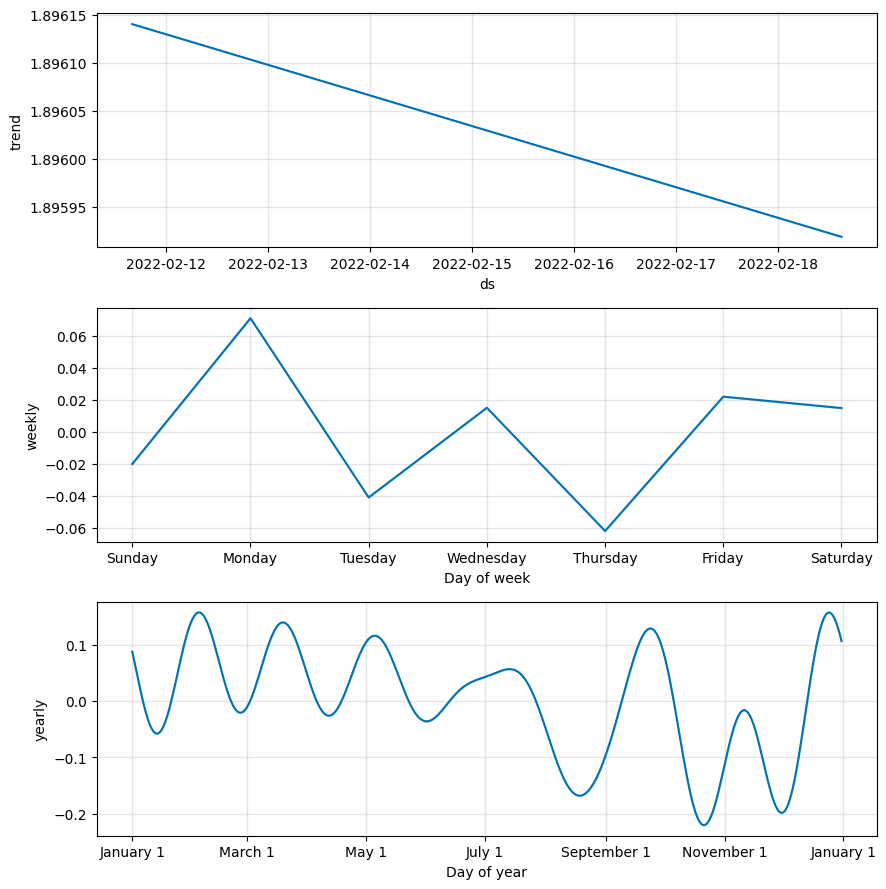

In [32]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

# Generating the dataset
n_samples = 1000  # Number of samples
np.random.seed(42)

# Generate synthetic categorical data
df = pd.DataFrame({
    "Demand_Level": np.random.choice(["Low", "Medium", "High"], size=n_samples, p=[0.3, 0.5, 0.2]),
    "Driver_Availability": np.random.choice(["Few", "Moderate", "Many"], size=n_samples, p=[0.4, 0.4, 0.2]),
    "Time_of_Day": np.random.choice(["Morning", "Afternoon", "Evening", "Night"], size=n_samples),
    "Vehicle_Type": np.random.choice(["Economy", "Premium"], size=n_samples, p=[0.7, 0.3]),
    "Date": pd.date_range(start='2022-01-01', periods=n_samples, freq='D')
})

# Simulating a target variable, for example 'Demand_Level' as numeric
df['Demand_Level_Numeric'] = df['Demand_Level'].map({"Low": 1, "Medium": 2, "High": 3})

# Prepare the data for Prophet: Prophet requires 'ds' (date) and 'y' (value to predict)
df_prophet = df[['Date', 'Demand_Level_Numeric']].rename(columns={'Date': 'ds', 'Demand_Level_Numeric': 'y'})

# Step 1: Instantiate and fit Prophet model with seasonality enabled
model = Prophet(
    yearly_seasonality=True,  # Enable yearly seasonality
    weekly_seasonality=True,  # Enable weekly seasonality
    daily_seasonality=False   # Disable daily seasonality since we have daily data
)

# Step 2: Fit the model
model.fit(df_prophet)

# Step 3: Create future DataFrame for forecasting using a separate approach
#future = model.make_future_dataframe(df_prophet[['ds']])  # Forecast for 1 year ahead (use only 'ds' column)

# Step 4: Make the forecast
forecast = model.predict(future)

# Step 5: Plot the forecast
plt.figure(figsize=(12, 6))
model.plot(forecast)
plt.title("Prophet Forecast with Weekly, Monthly, and Yearly Seasonality")
plt.show()

# Step 6: Plot the seasonal components
model.plot_components(forecast)
plt.show()

In [ ]:
!pip install NeuralProphet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.8/145.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20